#### Author: Arun Ramesh, University of Houston. https://rpglab.github.io/people/Arun-Venkatesh-Ramesh/
#### Source webpage: https://rpglab.github.io/resources/FL-ML-R-SCUC_Python/
#### If you use any codes/data here for your work, please cite the following paper: 
#####       Arun Venkatesh Ramesh and Xingpeng Li, “Feasibility Layer Aided Machine Learning Approach for Day-Ahead Operations”, IEEE Transactions on Power Systems, Apr. 2023.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
np.random.seed(1)

import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)

import csv
import time

In [2]:
##### data set 73 Bus 24 Prd

dfX_24 = pd.read_csv("demand73BusWBCorr24Prd.txt")
dfY_24 = pd.read_csv("commitment73BusWBCorr24Prd.txt")

print(dfX_24.info)
print(dfY_24.info)

x = dfX_24.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
x = x/100
print(x[1])

y = dfY_24.to_numpy()
#y = np.delete(y,0,1) #delete column one sample number
print(y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 20% for validation data that we never train over.
split_at = len(x) - len(x) // 5
(x_train, x_test) = x[:split_at], x[split_at:]
(y_train, y_test) = y[:split_at], y[split_at:]


print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(indices)

print(x_train[1])
print(y_train[1])

print(x_test[1])
print(y_test[1])

<bound method DataFrame.info of       88.95783123018604  79.89731138266708  148.26305205031005  \
0             70.842516          63.627074          118.070860   
1             67.207355          60.362162          112.012259   
2             93.489390          83.967322          155.815650   
3             86.466185          77.659444          144.110309   
4             74.007435          66.469641          123.345725   
...                 ...                ...                 ...   
1622          78.398487          70.478203          131.828147   
1623          76.769758          68.665458          127.748972   
1624          76.137279          69.789950          128.371584   
1625          80.614838          70.478658          134.990287   
1626          84.123750          76.299890          142.810523   

      60.952588065127465  58.4815371976223  112.02097266023425  \
0              48.540242         46.572395           89.209094   
1              46.049484         44.182613 

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1302, 1752)
(1302, 2376)
(325, 1752)
(325, 2376)


In [4]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim,2376))
    b = 0
    return w, b

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    return s

In [6]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of 
    size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    
    m = X.shape[0]
    
    #print(m)
    
    #print(w.shape)
    #print(X.shape)
    #print(b)
    b = np.sum(b)
    #print(b)
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)             # compute activation
    #print(A.shape)
    #print(Y.shape)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)   # compute cost
    #print(cost.shape)
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == (2376,))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [7]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        #if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        #if print_cost and i % 100 == 0:
        #    print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [8]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    #Y_prediction = np.zeros((792, m))
    w = w.reshape(X.shape[0], 2376)
    b = np.sum(b)
    
    # Compute vector "A" predicting the probabilities commitment
    A = sigmoid(np.dot(w.T, X) + b)
    #print (A.shape)
    #print(A.T)        
    return A

In [9]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [10]:
x_train = x_train.T
y_train = y_train.T

x_test = x_test.T
y_test = y_test.T

In [11]:
print (x_train.shape)
print (y_train.shape)

#learning_rates = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05]
learning_rates = [0.003]


models = {}
for i in learning_rates:
    tic = time.perf_counter()
    print ("learning rate is: ",i)
    models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = i, print_cost = True)
    toc = time.perf_counter()
    print(f"Time for training required: {toc - tic:0.4f} seconds")
    print ("-------------------------------------------------------")
    
    
#d = model(x_train, y_train, x_test, y_test, num_iterations = 700, learning_rate = 0.03, print_cost = True)

(1752, 1302)
(2376, 1302)
learning rate is:  0.003
train accuracy: 93.58248533943146 %
test accuracy: 93.56181678381513 %
Time for training required: 330.8776 seconds
-------------------------------------------------------


In [40]:
print(indices)

for i in learning_rates:
    print ("learning rate is: ",i)
    w = models[i]["w"]
    b = models[i]["b"]
    A_prediction_test = predict(w, b, x_test)
    A_prediction_test = A_prediction_test.T
    
    m = A_prediction_test.shape[0]
    Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
    P = 0.5

    for j in range(m):
        for i in range(A_prediction_test.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_test[j, i] >= P:
                Y_test_hackFull[j, i] = 1
            
            else:
                Y_test_hackFull[j, i] = 0
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
    A_prediction_train = predict(w, b, x_train)
    A_prediction_train = A_prediction_train.T
    
    m = A_prediction_train.shape[0]
    Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
    for j in range(m):
        for i in range(A_prediction_train.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_train[j, i] >= P:
                Y_train_hackFull[j, i] = 1
            
            else:
                Y_train_hackFull[j, i] = 0
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
    print ("-------------------------------------------------------")
    
    

[1087 1272  613 1493  201  382 1276   48  108 1549  268 1322  880 1147
  480  255 1070   91 1368 1610  547  194  406  264 1339  181  301  737
 1488  111 1094  258 1183  868  559 1546  826  299  870 1386 1253  285
 1038  786  481 1453  574 1475  348  602  535   75  885 1260  702  845
 1198  793 1314 1199 1388  401   60  421 1058    8  912 1477 1106 1406
  107  126 1359 1245  267 1395  464 1443  801 1007  663  302  653  389
  649 1030  336  447  920  671  167 1484  707  572  304 1591  368  427
 1333  223  664  241  400 1358   65  929 1432 1580 1415  824 1355  647
  921 1457    3 1342  231 1523  528   53  791  140 1338  951  892  952
 1194  161  275  372    0  902  678 1086  623  115  592  777  685  708
   30 1225  158 1189 1066  942  635   37 1085  701  292 1219  538  852
  453 1233  700  713 1470  478  632 1127 1012 1006  534   80  435  202
  101 1582  634  790  629 1566 1529  102  283 1269 1074 1128  895  990
 1023 1352  177 1383 1308  711 1419 1267  248 1451 1170  940  190 1403
 1330 

test accuracy: 95.26767676767676 %
train accuracy: 95.23541223810041 %
-------------------------------------------------------
learning rate is:  0.003
test accuracy: 95.96490546490547 %
train accuracy: 95.95846457405597 %
-------------------------------------------------------
learning rate is:  0.005
test accuracy: 94.5888370888371 %
train accuracy: 94.62378521518306 %
-------------------------------------------------------
learning rate is:  0.01
test accuracy: 94.28075628075628 %
train accuracy: 94.37151856506695 %
-------------------------------------------------------
learning rate is:  0.03
test accuracy: 93.93162393162393 %
train accuracy: 93.94892990323098 %
-------------------------------------------------------
learning rate is:  0.05
test accuracy: 94.06203056203056 %
train accuracy: 94.02466808380787 %
-------------------------------------------------------


In [12]:
i = 0.003
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.5

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

Y_test_closeness = np.zeros(Y_test_hackFull.shape[0])
for j in range(Y_test_hackFull.shape[0]):
    for k in range(Y_test_hackFull.shape[1]):
        Y_test_closeness[j] = Y_test_closeness[j] + np.abs(y_test.T[j,k] - Y_test_hackFull[j,k])
    Y_test_closeness[j] = (1- (Y_test_closeness[j]/Y_test_hackFull.shape[1]))*100

print(Y_test_closeness)
print(Y_test_closeness.shape)

learning rate is:  0.003
test accuracy: 95.96490546490547 %
train accuracy: 95.95846457405597 %
-------------------------------------------------------
[96.96969697 97.22222222 97.13804714 96.59090909 96.88552189 96.25420875
 97.0959596  94.99158249 93.85521886 94.02356902 95.83333333 97.01178451
 95.53872054 95.41245791 95.24410774 96.8013468  95.83333333 96.21212121
 97.01178451 97.01178451 97.18013468 95.37037037 96.12794613 96.25420875
 96.63299663 92.88720539 96.21212121 93.72895623 94.44444444 97.64309764
 96.8013468  95.28619529 95.83333333 95.37037037 96.38047138 97.76936027
 95.95959596 96.2962963  94.31818182 96.96969697 95.74915825 97.81144781
 95.53872054 96.71717172 95.79124579 96.38047138 93.77104377 94.36026936
 95.41245791 96.42255892 97.55892256 95.53872054 97.05387205 96.25420875
 97.43265993 96.67508418 96.92760943 95.2020202  96.38047138 94.61279461
 96.12794613 96.75925926 97.64309764 96.75925926 95.95959596 95.03367003
 95.53872054 96.0016835  96.75925926 97.09595

In [56]:
sample = 100

print(y_test.T[sample])
print(y_test.T[sample]-Y_test_hackFull[sample])
print(np.mean(Y_test_hackFull[sample]))
print(Y_test_hackFull[sample])
print(A_prediction_test[sample])

[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 1 1 1 1 1 1 1 

In [43]:
with open("commitment73Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_test_hackFull)

In [44]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand73Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [45]:
A_prediction_test_round = np.around(A_prediction_test, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities73Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_test_round)

In [46]:
with open("commitment73Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_train_hackFull)

In [47]:
x_train_round = np.around(x_train, decimals=3)
x_train_round = x_train_round.T
with open("demand73Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_train_round)

In [48]:
with open("probabilities73Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_train)

In [49]:
with open("UgtAct73Bus24PrdTest4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(y_test.T)

In [50]:
with open("UgtAct73Bus24PrdTrain4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(y_train.T)

In [19]:
##### data set out of sample

dfXoF_24 = pd.read_csv("demand73Bus24Prd_outofSampleVerificationOldDataset") #"Old/New"

print(dfXoF_24.info)

xoF = dfXoF_24.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
xoF = xoF/100

# Explicitly set apart 20% for validation data that we never train over.
split_at = 100
(x_oF, x_restoF) = xoF[:split_at], xoF[split_at:]

print(len(x_oF))

x_oF = x_oF.T

<bound method DataFrame.info of     73.18128903773255  65.72763922833387  121.96881506288759  \
0           50.537145          45.389843           84.228575   
1           45.993194          41.308702           76.655324   
2           78.845737          70.815153          131.409562   
3           70.066732          62.930305          116.777886   
4           54.493294          48.943051           90.822156   
..                ...                ...                 ...   
94          48.917573          43.935228           81.529289   
95          59.970436          53.862336           99.950727   
96          61.624336          55.347783          102.707226   
97          40.421226          36.304249           67.368709   
98          65.604662          58.922706          109.341103   

    50.14273508140935  48.109921497027884  92.15421582529285  \
0           34.627303           33.223493          63.639368   
1           31.513855           30.236267          57.917356   
2      

In [20]:
i = 0.003
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_oF = predict(w, b, x_oF)
A_prediction_oF = A_prediction_oF.T

learning rate is:  0.003


In [21]:
A_prediction_round_oF = np.around(A_prediction_oF, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities24Bus24PrdSample4Ampl_outofSample.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_round_oF)

In [22]:
x_round_oF = np.around(x_oF, decimals=4)
x_round_oF = x_round_oF.T
with open("demand24Bus24PrdSample4Ampl_outofSample.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_round_oF)

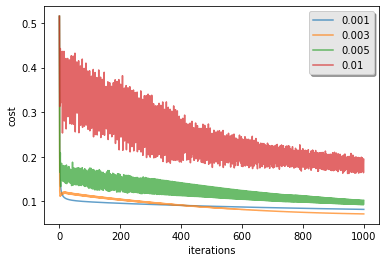

[[0.5151128  0.19859157 0.15825545 0.14157861 0.13233162 0.12642517
  0.1223155  0.11928603 0.11695757 0.11511021 0.11360745 0.11236005
  0.11130711 0.11040571 0.10962466 0.10894079 0.1083365  0.1077982
  0.10731522 0.10687908 0.10648293 0.10612119 0.10578929 0.10548342
  0.10520039 0.1049375  0.10469249 0.1044634  0.10424855 0.10404649
  0.10385596 0.10367586 0.10350522 0.10334321 0.10318906 0.1030421
  0.10290176 0.10276749 0.10263883 0.10251534 0.10239664 0.10228239
  0.10217227 0.10206599 0.10196331 0.10186397 0.10176776 0.10167448
  0.10158397 0.10149603 0.10141053 0.10132732 0.10124627 0.10116727
  0.10109018 0.10101493 0.1009414  0.1008695  0.10079916 0.1007303
  0.10066284 0.10059671 0.10053186 0.10046822 0.10040573 0.10034435
  0.10028402 0.1002247  0.10016635 0.10010892 0.10005237 0.09999667
  0.09994179 0.09988769 0.09983433 0.0997817  0.09972977 0.0996785
  0.09962787 0.09957786 0.09952845 0.09947962 0.09943134 0.09938359
  0.09933636 0.09928964 0.09924339 0.09919762 0.0991

In [28]:
plt.clf()

NCost = int(models[0.003]["num_iterations"])#/100)

costarray_full = np.zeros((len(learning_rates),NCost))
costarray_single = np.zeros(NCost)

#print (NCost)
for i in range(4):#len(learning_rates)):
    costarray_single = np.zeros(NCost)
    for j in range(NCost):
        #print (j)
        costarray_single[j] = np.mean(np.squeeze(models[learning_rates[i]]["costs"][j])) 
    costarray_full[i] = costarray_single
    plt.plot(costarray_full[i], label= str(models[learning_rates[i]]["learning_rate"]),alpha=0.7)
    #print (np.squeeze(models[i]["costs"][2]))

#plt.plot(costarray_full[i], label= str(models[0.001]["learning_rate"]), alpha=1)
#plt.plot(np.squeeze(models[0.001]["costs"][1]), label= str(models[0.001]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

print (costarray_full)

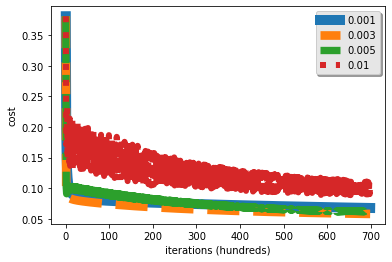

In [74]:
plt.clf()
grid=[x for x in range(700)]
i = 0
for gg,graph in enumerate(costarray_full[0:4]):
    lw=10-8*gg/len(costarray_full)
    ls=['-','--','-.',':'][gg%4]
    plt.plot(grid,graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    i = i+1
    
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [49]:
for j in range(m):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27